# Record Disambiguation

In this notebook we perform entity disambiguation on records, specifically person records.

In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display, Markdown

from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm

import sys
sys.path.append("..")

from heritageconnector.disambiguation.helpers import load_training_data, plot_performance_curves, filter_top_ranked_results
from heritageconnector.disambiguation.pipelines import Disambiguator
from heritageconnector.utils.wikidata import get_sparql_results, url_to_qid
from heritageconnector.utils.generic import paginate_list
from heritageconnector.config import config

pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)

## 1. Load data
This data has already been generated using `Disambiguator.save_training_data_to_folder` and `Disambiguator.save_test_data_to_folder`.

In [20]:
train_dir = "/Volumes/Kalyan_SSD/SMG/disambiguation/organisations_281020/train/"
test_dir = "/Volumes/Kalyan_SSD/SMG/disambiguation/organisations_281020/test/"

In [21]:
X, y, pairs, pids = load_training_data(train_dir)
X_new, pairs_new, pids_new = load_training_data(test_dir)

In [4]:
pids, pids_new

(['P571', 'P576', 'label', 'P31'], ['P571', 'P576', 'label', 'P31'])

In [6]:
X.sum(axis=0), X_new.sum(axis=0)

(array([ 2065.48057614,   390.65041494, 10511.09999183,  1885.55965347]),
 array([ 7076.74729307,   871.75928628, 87867.67991152, 12585.86794357]))

In [22]:
pairs.head()

,internal_id,wikidata_id,is_type
0,https://collection.sciencemuseumgroup.org.uk/people/cp160635,Q54957046,True
1,https://collection.sciencemuseumgroup.org.uk/people/cp160635,Q4356031,False
2,https://collection.sciencemuseumgroup.org.uk/people/cp160635,Q1025696,False
3,https://collection.sciencemuseumgroup.org.uk/people/cp160635,Q92038108,False
4,https://collection.sciencemuseumgroup.org.uk/people/cp160635,Q54979507,True


## 2. Train classifier
The disambiguator wraps `sklearn.tree.DecisionTreeClassifier` and takes its parameters as inputs.

### 2a. Test classifier performance
We'll perform a train/test split on the labelled data to quickly test the classifier's performance using its `score` method. 

The `score` method here returns [balanced accuracy](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.balanced_accuracy_score.html): accuracy weighted so that each class is considered evenly.

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.1)

In [9]:
clf = Disambiguator('ORGANISATION').fit(X_train, y_train)
print(clf.score(X_test, y_test, threshold=0.6))

balanced accuracy score: 0.9236230813428548
precision score: 0.45901639344262296
recall score: 0.9032258064516129


### 2b. Use classifier to predict new Wikidata links

In [10]:
clf = Disambiguator('ORGANISATION').fit(X, y)
y_pred = clf.predict(X_new, threshold=0.6)
y_pred_proba = clf.predict_proba(X_new)

print(f"{np.unique(y_pred, return_counts=True)[1][1]} potential new links found")

4050 potential new links found


In [13]:
pairs_new["y_pred"] = y_pred
pairs_new["y_pred_proba"] = y_pred_proba

The graph below shows the distribution of the number of predicted matches per SMG ID. Around 75% have a unique match, and most of the remainder have two matches.

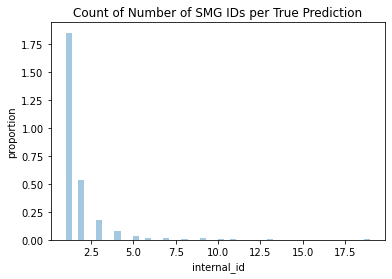

In [14]:
display(Markdown("The graph below shows the distribution of the number of predicted matches per SMG ID. Around 75% have a unique match, and most of the remainder have two matches."))
sns.distplot(pairs_new.loc[pairs_new["y_pred"] == True, "internal_id"].value_counts(), kde=False, norm_hist=True).set_ylabel('proportion')
plt.gca().set_title('Count of Number of SMG IDs per True Prediction');

## 2c. Returning top-ranked links only
We can filter some of the duplicate Wikidata candidates for each SMG item found above by _only returning the top-ranked positive matches_. `clf.predict_top_ranked_pairs` does this.

In [15]:
pairs_true = clf.predict_top_ranked_pairs(X_new, pairs_new, threshold=0.8)
print(f"No. new links: {len(pairs_true)}")
print(f"No. SMG items with new links: {len(pairs_true['internal_id'].unique())}")
pairs_true.head(20)

No. new links: 3543
No. SMG items with new links: 2283


,internal_id,wikidata_id,is_type,y_pred,y_pred_proba
60,https://collection.sciencemuseumgroup.org.uk/people/cp16435,Q56557888,True,True,0.910068
62,https://collection.sciencemuseumgroup.org.uk/people/cp16435,Q19872846,True,True,0.910068
63,https://collection.sciencemuseumgroup.org.uk/people/cp16435,Q5260325,True,True,0.910068
64,https://collection.sciencemuseumgroup.org.uk/people/cp16435,Q4294371,True,True,0.910068
66,https://collection.sciencemuseumgroup.org.uk/people/cp16435,Q3315315,True,True,0.910068
70,https://collection.sciencemuseumgroup.org.uk/people/cp16435,Q74529046,True,True,0.910068
72,https://collection.sciencemuseumgroup.org.uk/people/cp16435,Q16956091,True,True,0.910068
73,https://collection.sciencemuseumgroup.org.uk/people/cp16435,Q1312371,True,True,0.910068
75,https://collection.sciencemuseumgroup.org.uk/people/cp16435,Q3044742,True,True,0.910068
76,https://collection.sciencemuseumgroup.org.uk/people/cp16435,Q4294368,True,True,0.910068


## 2d. Filter matches

By type, number of links

In [19]:
max_links_per_record = 4
pairs_true_filtered = filter_top_ranked_results(pairs_true, enforce_correct_type=True, max_wikidata_links=4)

print("-- After Filtering --")
print(f"No. new links: {len(pairs_true_filtered)}")
print(f"No. SMG items with new links: {len(pairs_true_filtered['internal_id'].unique())}")

pairs_true_filtered.head(10)

-- After Filtering --
No. new links: 2853
No. SMG items with new links: 2150


,internal_id,wikidata_id,is_type,y_pred,y_pred_proba
240,https://collection.sciencemuseumgroup.org.uk/people/cp67907,Q5477830,True,True,0.910068
243,https://collection.sciencemuseumgroup.org.uk/people/cp67907,Q5477832,True,True,0.910068
244,https://collection.sciencemuseumgroup.org.uk/people/cp67907,Q22268903,True,True,0.910068
290,https://collection.sciencemuseumgroup.org.uk/people/cp63077,Q46974,True,True,0.995691
456,https://collection.sciencemuseumgroup.org.uk/people/cp124541,Q10298417,True,True,0.910068
459,https://collection.sciencemuseumgroup.org.uk/people/cp124541,Q86684705,True,True,0.910068
462,https://collection.sciencemuseumgroup.org.uk/people/cp124541,Q6852052,True,True,0.910068
491,https://collection.sciencemuseumgroup.org.uk/people/cp40755,Q1739094,True,True,0.910068
540,https://collection.sciencemuseumgroup.org.uk/people/cp53005,Q48792266,True,True,0.910068
578,https://collection.sciencemuseumgroup.org.uk/people/cp20304,Q30261908,True,True,0.910068


## 3. Explain classifier
We can see that the classifier prioritises P569/P570 (birth and death dates), P21 (gender), label similarity, and occupation.

It's interesting to note that P31 (instance of), which tells the classifier whether the Wikidata record is a human, is not used. This is likely because P569/P570/P106/P21 are qualities which only humans can have.

P31 is likely to be much more prevalent when classifying objects, and distinguishing between e.g. paintings and posters.

In [120]:
clf.print_tree(feature_names=pids + ['class_tree'])

|--- class_tree <= 0.50
|   |--- P576 <= 1.00
|   |   |--- P31 <= 0.42
|   |   |   |--- P571 <= 0.98
|   |   |   |   |--- label <= 0.83
|   |   |   |   |   |--- class: False
|   |   |   |   |--- label >  0.83
|   |   |   |   |   |--- class: False
|   |   |   |--- P571 >  0.98
|   |   |   |   |--- P571 <= 0.98
|   |   |   |   |   |--- class: True
|   |   |   |   |--- P571 >  0.98
|   |   |   |   |   |--- class: False
|   |   |--- P31 >  0.42
|   |   |   |--- P571 <= 0.45
|   |   |   |   |--- label <= 0.96
|   |   |   |   |   |--- class: False
|   |   |   |   |--- label >  0.96
|   |   |   |   |   |--- class: True
|   |   |   |--- P571 >  0.45
|   |   |   |   |--- P571 <= 0.98
|   |   |   |   |   |--- class: False
|   |   |   |   |--- P571 >  0.98
|   |   |   |   |   |--- class: False
|   |--- P576 >  1.00
|   |   |--- class: True
|--- class_tree >  0.50
|   |--- label <= 0.91
|   |   |--- P571 <= 1.00
|   |   |   |--- label <= 0.88
|   |   |   |   |--- label <= 0.81
|   |   |   |   |   

## 4. Export model & sample of predictions

In [24]:
clf.save_classifier_to_disk("/Volumes/Kalyan_SSD/SMG/disambiguation/organisations_281020/clf.pkl")
pairs_true_filtered.to_csv("/Volumes/Kalyan_SSD/SMG/disambiguation/organisations_281020/orgs_preds_positive.csv", index=False)